#Relly Erlinda

Analisis ini dilakukan untuk memahami faktor-faktor yang memengaruhi fluktuasi penjualan mingguan di berbagai toko. Data mencakup periode februari 2010 hingga oktober 2012 dengan variabel ekonomi dan eksternal seperti CPI, Unemployment, temperature dan fuel price. Tujuannya adalah untuk mengidentifikasi tren, hubungan antar variabel serta memberikan rekomendasi berbasis data terhadap strategi bisnis.

In [80]:
#Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from prophet import Prophet

#Load Data

In [2]:
df = pd.read_excel("Data Penjualan department store.xlsx")
df.head()

,Store,Date,Weekly_Sales,Holiday,temperature,fuel price,CPI,unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


#Cleaning Data

In [3]:
# Pastikan kolom Date bertipe datetime
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
# Cek missing value
print(df.isnull().sum())

Store           0
Date            0
Weekly_Sales    0
Holiday         0
temperature     0
fuel price      0
CPI             0
unemployment    0
dtype: int64


In [5]:
# Cek tipe data
df.info()
df.rename(columns={'fuel price':'fuel_price'}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday       6435 non-null   int64         
 4   temperature   6435 non-null   float64       
 5   fuel price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [6]:
df.describe()

,Store,Date,Weekly_Sales,Holiday,temperature,fuel_price,CPI,unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


Dataset mencakup data dari 45 toko dengan periode waktu antara Februari 2010 hingga Oktober 2012. Selama periode tersebut, rata-rata penjualan mingguan per toko tercatat sebesar Rp 1.046.965 dengan variasi yang cukup besar, dari Rp 209.986 hingga mencapai Rp 3.818.686. Rentang penjualan yang lebar menunjukkan adanya perbedaan performa antar toko yang signifikan, bisa disebabkan oleh lokasi, ukuran toko atau strategi promosi.
Nilai holiday memiliki mean 0.0699, artinya sekitar 7% dari total minggu merupakan minggu libur besar seperti Natal, Tahun baru atau thanksgiving.
Fluktuasi harga bahan bakar dapat memengaruhi biaya logistik dan daya beli konsumen.

#Eksplorasi

Analisis Tren Penjualan (Seluruh Toko)

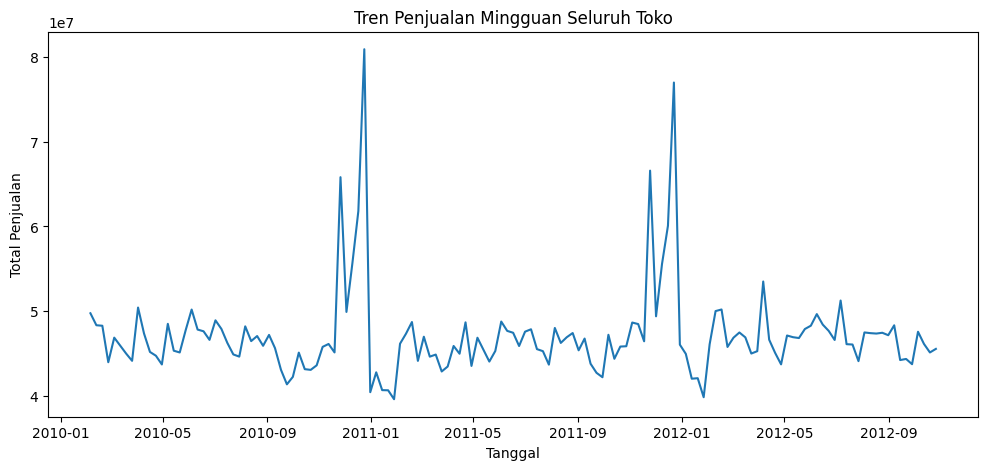

In [7]:
trend = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(x='Date', y='Weekly_Sales', data=trend)
plt.title('Tren Penjualan Mingguan Seluruh Toko')
plt.xlabel('Tanggal')
plt.ylabel('Total Penjualan')
plt.show()

Berdasarkan grafik di atas, terlihat ada lonjakan signifikan menjelang awal tahun 2011 dan 2012, kemungkinan besar terkait liburan akhir tahun, atau promosi musiman. Secara umum, penjualan relatif stabil sepanjang tahun, dengan fluktuasi mingguan kurang lebih 4-5 juta. Penjualan puncak terjadi ketika musim liburam, ini bisa jadi periode prioritas untuk stok dan promosi.

Analisis Hari Libur

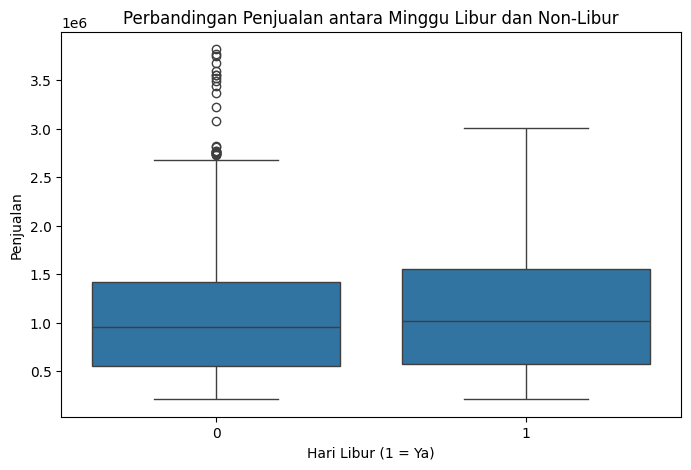

In [8]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Holiday', y='Weekly_Sales', data=df)
plt.title('Perbandingan Penjualan antara Minggu Libur dan Non-Libur')
plt.xlabel('Hari Libur (1 = Ya)')
plt.ylabel('Penjualan')
plt.show()

Berdasarkan box plot di atas, median penjualan ketika libur sedikit lebih tinggi dan ada beberapa outlier di minggu non libur dengan penjualan tinggi. Liburan memang meningkatkan penjualan sedikit, tapi minggu non libur juga bisa punya penjualan tinggi. Strategi promosi bisa fokus pada minggu libur, tapi jangan lupakan minggu non libur yang potensial.

Top 10 toko dengan rata-rata penjualan tertinggi

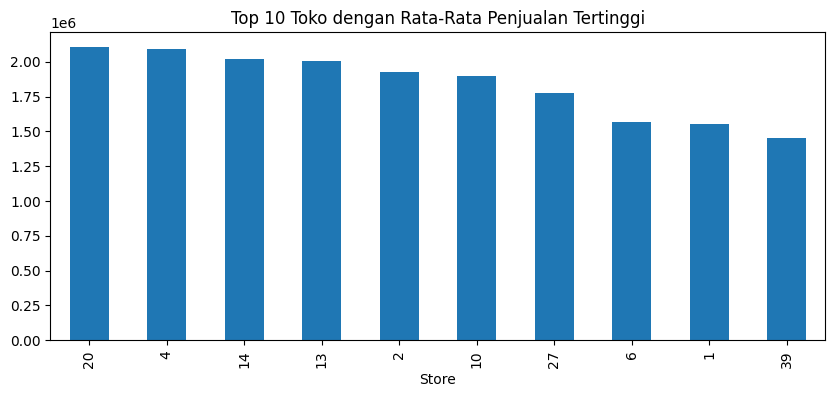

In [9]:
store_summary = df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)
store_summary.head(10).plot(kind='bar', figsize=(10,4), title='Top 10 Toko dengan Rata-Rata Penjualan Tertinggi')
plt.show()

Grafik di atas menunjukkan bahwa Store 20, 4, 14, dan 13 memiliki rata-rata penjualan mingguan tertinggi di antara seluruh toko. Hal ini mengindikasikan bahwa toko-toko tersebut beroperasi di wilayah dengan permintaan pelanggan yang tinggi atau strategi operasional yang lebih efektif (misalnya tata letak, promosi, atau manajemen stok yang baik).
Sementara itu, toko seperti Store 1 dan Store 39, meskipun termasuk 10 besar, memiliki rata-rata penjualan yang lebih rendah dibandingkan toko teratas.

Analisis Korelasi antar Variabel

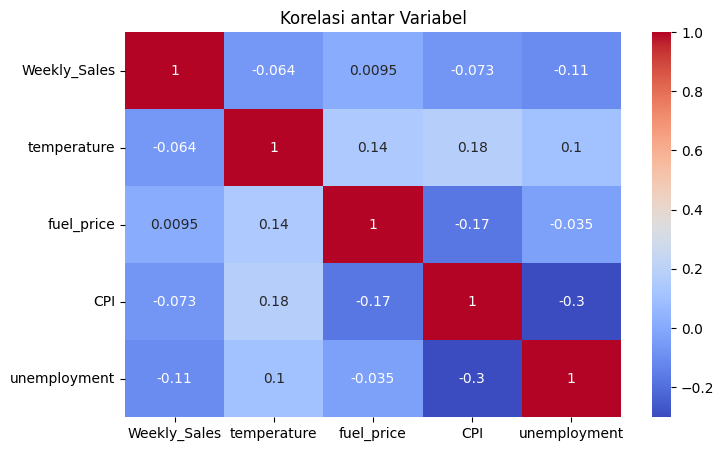

In [10]:
plt.figure(figsize=(8,5))
sns.heatmap(df[['Weekly_Sales','temperature','fuel_price','CPI','unemployment']].corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi antar Variabel')
plt.show()

Weekly sales memiliki korelasi negatif kecil dengan unemployment dan CPI yang berarti penjualan sedikit menurun ketika ekonomi memburuk atau inflasi naik. Korelasi dengan temperature dan fuel price gampir nol, artinya faktor cuaca dan bahan bakar tidak terlalu memengaruhi penjualan total. Penjualan lebih sensitif terhadap faktor ekonomi makro daripada faktor eksternal seperti cuaca.

#Forecasting Menggunakan SARIMAX

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [13]:
df = pd.read_excel("Data Penjualan department store.xlsx")
df.head()

,Store,Date,Weekly_Sales,Holiday,temperature,fuel price,CPI,unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


Store 1

In [63]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [64]:
df = df.sort_values(by=['Store', 'Date'])

In [65]:
store_id = 1
store_df = df[df['Store'] == store_id].copy()

In [66]:
store_df = store_df.set_index('Date')

In [67]:
y = store_df['Weekly_Sales']
exog_vars = ['Holiday', 'temperature', 'fuel price', 'CPI', 'unemployment']
X = store_df[exog_vars]

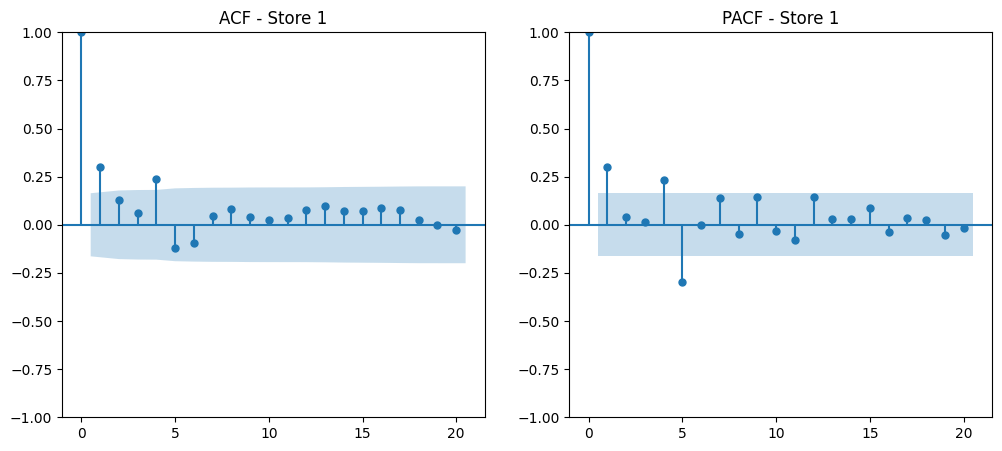

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plot_acf(y, ax=ax[0], lags=20, title="ACF - Store 1")
plot_pacf(y, ax=ax[1], lags=20, title="PACF - Store 1")
plt.show()

Berdasarkan hasil analisis plot ACF dan PACF store 1, ditemukan bahwa terdapat spike signifikan pada lag ke-1 baik pada grafik ACF maupun PACF. Setelah lag pertama, nilai autokorelasi menurun dengan cepat menuju nol, yang mengindikasikan adanya pola ketergantungan jangka pendek antara penjualan minggu ini dengan minggu sebelumnya.
Hasil ini menunjukkan bahwa penjualan di Store 1 cenderung dipengaruhi oleh pola historis jangka pendek, di mana performa penjualan satu minggu sebelumnya memiliki dampak langsung terhadap penjualan minggu berikutnya.

In [69]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(y)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -5.102186
p-value: 0.000014


Dengan mempertimbangkan hasil uji ADF yang menunjukkan p-value < 0.05, dapat disimpulkan bahwa data pada store 1 sudah stasioner, sehingga tidak memerlukan differencing (d=0). Kondisi tersebut memungkinkan penggunakan model SARIMAX (1,0,1) untuk menangkap hubungan antara penjualan saat ini dan periode sebelumnya, dengan tambahan variabel eksternal seperti (CPI, fuel price, unemployment) untuk memperhitungkan pengaruh faktor ekonomi makro.

Dalam model ini, komponen AR(1) menggambarkan adanya pengaruh dari penjualan minggu sebelumnya, sedangkan komponen MA(1) menangkap efek gangguan acak seperti fluktuasi permintaan atau kegiatan promosi jangka pendek.
Dengan demikian, perubahan penjualan di Store 1 tidak hanya dipengaruhi oleh pola internal toko, tetapi juga oleh perubahan kondisi ekonomi dan faktor eksternal lainnya.

In [70]:
model = SARIMAX(y, exog=X, order=(1, 0, 1), seasonal_order=(1, 0, 1, 52), enforce_stationarity=False, enforce_invertibility=False)
result = model.fit(disp=False)
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood               -1147.571
Date:                            Sun, 02 Nov 2025   AIC                           2315.142
Time:                                    12:35:15   BIC                           2340.029
Sample:                                02-05-2010   HQIC                          2325.173
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Holiday       9.582e+04   1.17e+06      0.082      0.935    -2.2e+06     2.4e+06
temperature  -2454.1879   707

1. Holiday memiliki nilai p-value 0.925 yang berarti tidak signifikan. Artinya, periode libur tidak memberikan pengaruh yang berarti terhadap penjualan mingguan di toko ini. Mungkin karena konsumen berbelanja stabil sepanjang tahun atau promosi saat liburan tidak berdampak besar.
2. Temperatur juga tidak signifikan. Nilai negatif kecil ini menunjukkan bahwa kenaikan suhu sedikit menurunkan penjualan, namun efeknya lemah dan tidak signifikan secara statistik.
3. Fuel price tidak signifikan. Perubahan harga bahan bakar tidak secara langsung memengaruhi jumlah penjualan, kemungkinan karena konsumen tetap melakukan pembelian meskipun biaya transportasi naik.
4. Untuk CPI hampir signifikan pada taraf 10%. Koefisien positif menunjukkan bahwa kenaikan CPI justru diikuti oleh peningkatan penjualan, kemungkinan karena barang-barang kebutuhan pokok masih tetap dibeli meskipun harga naik.
5. Unemployment juga tidak signifikan. Artinya, perubahan tingkat pengangguran tidak berpengaruh langsung terhadap volume penjualan mingguan toko ini. Hal ini bisa terjadi jika segmen pelanggan toko ini relatif tidak terlalu terpengaruh oleh kondisi ekonomi lokal.

Tidak ada variabel eksternal yang signifikan secara statistik pada taraf 5%, namun CPI menunjukkan kecenderungan pengaruh positif, sehingga faktor ekonomi makro masih perlu diperhatikan dalam strategi jangka panjang.

1. Nilai AR(1) = 0.1019 mengindikasikan adanya hubungan positif lemah antara penjualan minggu ini dengan minggu sebelumnya. Namun nilainya sangat kecil dan tidak signifikan.
2. Nilai MA(1) = -0.0167 menunjukkan efek kesalahan prediksi minggu sebelumnya terhadap penjualan minggu ini sangat kecil dan tidak signifikan.
3. Nilai AR.S(52) = 0.9822 menunjukkan adanya pola musiman tahunan yang cukup kuat, penjualan pada minggu tertentu cenderung menyerupai penjualan pada minggu yang sama di tahun sebelumnya. Ini adalah temuan penting karena menunjukkan adanya siklus tahunan yang perlu diperhatikan dalam perencanaan stok dan promosi.
4. Nilai MA.S(52) = -0.1914 menandakan adanya efek acak musiman, namun lemah dan tidak signifikan.

Uji diagnostik Model:
1. Ljung-Box Q = 0.19 (p = 0.67) artinya  tidak ada autokorelasi residual yang signifikan, model sudah cukup mampu menjelaskan pola dalam data.
2. Jarque-Bera = 13.89, p = 0.00, artinya residual tidak sepenuhnya normal, menunjukkan adanya sedikit outlier atau fluktuasi tajam pada beberapa minggu.
3. Kurtosis = 4.37 menunjukkan distribusi residual agak “peaked” (lebih tajam dari normal), umum terjadi pada data penjualan musiman.
4. Heteroskedasticity = 1.52, p = 0.25 menunjukkan bahwa tidak ditemukan masalah varians yang berubah-ubah.

In [71]:
future_dates = pd.date_range(start=store_df.index[-1] + pd.Timedelta(weeks=1), periods=12, freq='W')


In [72]:
future_exog = pd.DataFrame([X.iloc[-1].values] * 12, columns=exog_vars, index=future_dates)

In [73]:
forecast = result.get_forecast(steps=12, exog=future_exog)
forecast_df = forecast.summary_frame()

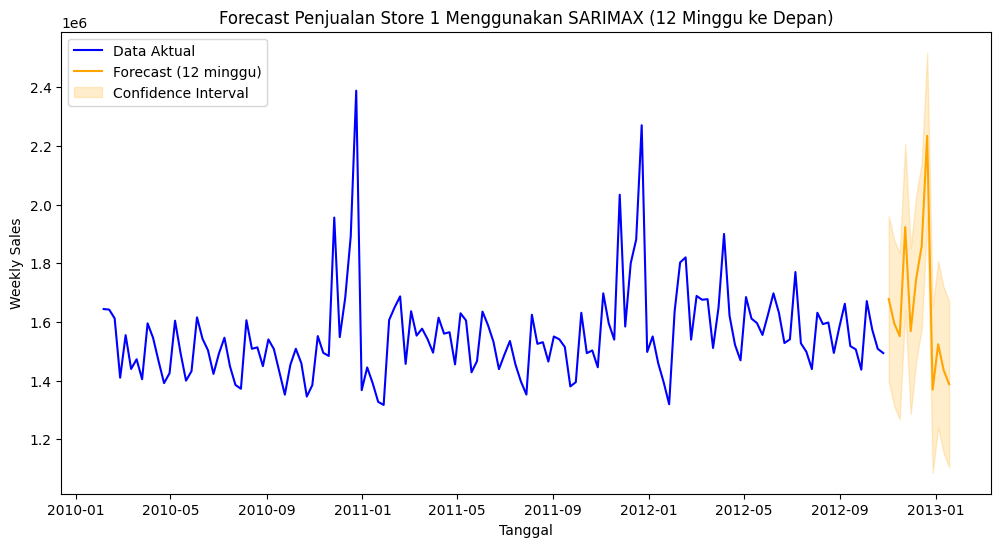

In [74]:
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label='Data Aktual', color='blue')
plt.plot(forecast_df.index, forecast_df['mean'], label='Forecast (12 minggu)', color='orange')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'],
                 color='orange', alpha=0.2, label='Confidence Interval')
plt.title(f'Forecast Penjualan Store {store_id} Menggunakan SARIMAX (12 Minggu ke Depan)')
plt.xlabel('Tanggal')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

Hasil forecast menunjukkan bahwa:
1. Pola penjualan pada periode prediksi masih mengikuti tren historis, dengan kecenderungan berfluktuasi di sekitar rata-rata historis.
2. Interval kepercayaan relatif melebar di akhir periode, menandakan bahwa ketidakpastian prediksi meningkat seiring jarak waktu yang lebih jauh dari data historis.
3. Secara umum, model mampu menangkap pola musiman tahunan yang terjadi pada data, tetapi tidak menunjukkan adanya tren naik atau turun yang kuat dalam jangka pendek.

KESIMPULAN:
Penjualan diprediksi akan tetap stabil dengan sedikit fluktuasi di sekitar nilai rata-rata penjualan historis. Hal ini menunjukkan kondisi pasar yang relatif konstan tanpa indikasi perubahan besar dalam permintaan.

REKOMENDASI:
1. Pertahankan strategi penjualan yang konsisten karena tidak ada indikasi penurunan signifikan.
2. Siapkan stok tambahan menjelang periode musiman yang biasanya menunjukkan lonjakan penjualan (misalnya akhir tahun atau libur panjang).
3. Lakukan evaluasi ulang model jika terjadi perubahan ekonomi atau faktor eksternal signifikan seperti perubahan harga bahan bakar atau inflasi.

Store 2

In [75]:
store_id_2 = 2
store_df = df[df['Store'] == store_id_2].copy()
store_df = store_df.set_index('Date')
y = store_df['Weekly_Sales']
exog_vars = ['Holiday', 'temperature', 'fuel price', 'CPI', 'unemployment']
X = store_df[exog_vars]

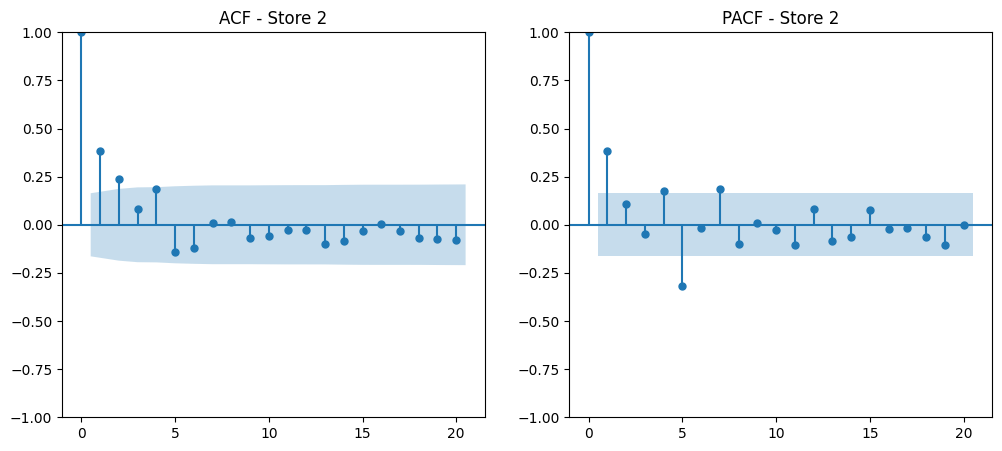

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plot_acf(y, ax=ax[0], lags=20, title="ACF - Store 2")
plot_pacf(y, ax=ax[1], lags=20, title="PACF - Store 2")
plt.show()

Hasil analisis untuk Store 2 menunjukkan pola yang serupa. Grafik ACF memperlihatkan spike kuat pada lag ke-1, sementara PACF menunjukkan satu spike dominan yang kemudian cepat menurun. Pola ini menandakan adanya autokorelasi positif jangka pendek, sehingga penjualan di minggu sebelumnya berkontribusi terhadap variasi penjualan minggu berjalan.

In [79]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test for stationarity
adf_test = adfuller(y)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.708863
p-value: 0.003990


Uji ADF menghasilkan p < 0,05, menandakan bahwa data sudah stasioner tanpa perlu dilakukan differencing. Model SARIMAX(1,0,1) kemudian digunakan untuk menggambarkan pola tersebut dengan mempertimbangkan pengaruh variabel ekonomi eksternal.

In [59]:
model = SARIMAX(y, exog=X, order=(1, 0, 1), seasonal_order=(1, 0, 1, 52), enforce_stationarity=False, enforce_invertibility=False)
result = model.fit(disp=False)
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood               -1179.565
Date:                            Sun, 02 Nov 2025   AIC                           2379.130
Time:                                    12:13:39   BIC                           2404.017
Sample:                                02-05-2010   HQIC                          2389.161
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Holiday       1.049e+05    1.4e+06      0.075      0.940   -2.65e+06    2.86e+06
temperature  -3699.8581   1.2

Model SARIMAX sudah cukup baik menangkap pola data tanpa autokorelasi sisa yang berarti, meskipun masih terdapat sedikit penyimpangan distribusi akibat fluktuasi ekstrem pada beberapa periode penjualan.

Model SARIMAX untuk Store 2 mengindikasikan bahwa:
1. Faktor internal dan pola musiman tahunan memiliki peran lebih besar dalam menentukan penjualan dibanding faktor eksternal.
2. Inflasi (CPI) berpotensi berpengaruh positif terhadap nilai penjualan, mungkin karena harga barang meningkat sehingga total nominal penjualan juga naik.
3. Penjualan tidak terlalu terpengaruh oleh perubahan suhu, harga bahan bakar, atau tingkat pengangguran.

Dengan demikian, performa Store 2 cenderung stabil secara struktural namun mengalami fluktuasi musiman tahunan yang signifikan.

In [60]:
future_dates = pd.date_range(start=store_df.index[-1] + pd.Timedelta(weeks=1), periods=12, freq='W')
future_exog = pd.DataFrame([X.iloc[-1].values] * 12, columns=exog_vars, index=future_dates)
forecast = result.get_forecast(steps=12, exog=future_exog)
forecast_df = forecast.summary_frame()

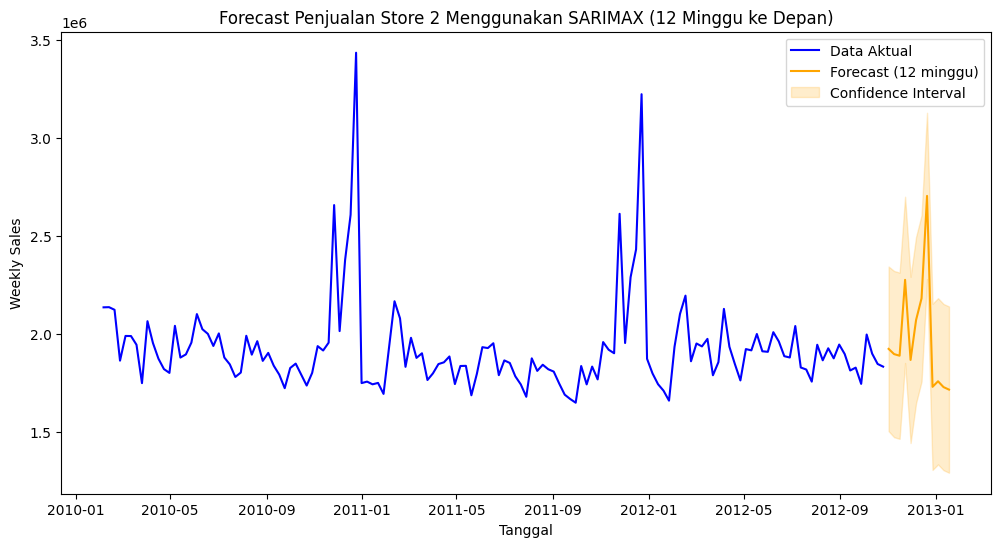

In [61]:
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label='Data Aktual', color='blue')
plt.plot(forecast_df.index, forecast_df['mean'], label='Forecast (12 minggu)', color='orange')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'],
                 color='orange', alpha=0.2, label='Confidence Interval')
plt.title(f'Forecast Penjualan Store {store_id_2} Menggunakan SARIMAX (12 Minggu ke Depan)')
plt.xlabel('Tanggal')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

Hasil forecast menunjukkan bahwa:
1. Prediksi penjualan tetap berada dalam kisaran historis, dengan kecenderungan stabil di sekitar nilai rata-rata sebelumnya.
2. Interval kepercayaan juga melebar di akhir periode, yang mengindikasikan peningkatan ketidakpastian prediksi jangka panjang.
3. Tidak terdapat indikasi tren naik atau turun yang signifikan, namun kemungkinan lonjakan musiman tetap ada.

KESIMPULAN:
Penjualan Store 2 diperkirakan akan tetap stabil dengan potensi lonjakan sementara pada periode tertentu. Variasi yang lebih tinggi dibandingkan Store 1 menunjukkan bahwa Store 2 lebih dipengaruhi oleh faktor-faktor eksternal seperti promosi, hari libur, atau kondisi ekonomi setempat.

REKOMENDASI:
1. Fokuskan strategi promosi pada periode musiman yang berpotensi meningkatkan penjualan.
2. Monitor variabel ekonomi seperti CPI dan unemployment rate, karena keduanya bisa memengaruhi daya beli konsumen.
3. Perlu pengawasan ketat terhadap stok barang untuk mengantisipasi lonjakan permintaan mendadak.